In [28]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
#from IPython.display import display, Math
import matplotlib as mpl
from multiprocessing.pool import Pool
from mcmc_functions import *
import pickle
import h5py
import glob
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


In [48]:
################################################
#    comparing MCMC fits for clean+avg 
################################################
df_str = 'sn20ano'
plot_name = '20ano'

#old version
sn20ano = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20ano.csv')
#r1_g, r1_r = True, True
print(sn20ano.columns)

#new version
sn20ano_cl = pd.read_csv('./cleaning/outputs/sn20ano_cleaned_binned_cut.csv')
sn20ano_cl['JD'] = sn20ano_cl['mjd']+2400000.5
sn20ano_cl['mag_err_all'] = sn20ano_cl['err']

a2_ind = 40

norm_LC_a2(sn20ano_cl, a2_ind)

sn20ano_cl,a2 = subselect(sn20ano_cl)
#r1_g, r1_r = False, True
sn20ano_cl.columns

Index(['JD', 'filter', 'mag', 'ztf_mag_lower', 'ztf_mag_upper',
       'atlas_mag_err', 'data_origin', 'norm_t', 'norm_m', 'max_ztf_err',
       'mag_err_all'],
      dtype='object')
JD @ a2 =  2458877.7548206


25

In [30]:
# if code crashes, reload the chains here to find bestfit
# g_chains = []
# r_chains = []
# for i in range(len(df_str_list)):
#     save_dir = './mcmc_fp_results/flatchains/'
#     gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
#     rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
#     g_chains.append(gf)
#     r_chains.append(rf)

def bestfit_recovery(filename, sub_df, band='', r1_bool=True, sn_id_band='test_g', replot=False, save=False):
    flat_samples = np.loadtxt(filename)
    if r1_bool:
        ndim = 7
    if not r1_bool:
        ndim = 5

    mcmc_results = []
    #retrieve the 16th/50th/84th percentile for each param and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)

    # making fit/autocorr/corner plots
    if band == 'g':
        g_df = sub_df[(sub_df['filter']=='ZTF_g') | (sub_df['filter']=='c')]
        x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    if band == 'r':
        r_df = sub_df[(sub_df['filter']=='ZTF_r') | (sub_df['filter']=='o')]
        x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    if replot:
        plot_mcmc_results(x, y, yerr, mcmc_results, flat_samples, r1=r1_bool, sn_band=sn_id_band, save=save)
        do_gw_autocorr_and_plot(filename, sn_id_band, save=save)

    return mcmc_results#,flat_samples

In [31]:
sn20ano_old_fit_g = bestfit_recovery('./mcmc_fp_results/flatchains/sn20ano_g_flatchains.txt',
                                     sn20ano, band='g', r1_bool=True, sn_id_band='sn20ano_g', replot=False)
sn20ano_old_fit_r = bestfit_recovery('./mcmc_fp_results/flatchains/sn20ano_r_flatchains.txt',
                                     sn20ano, band='r', r1_bool=True, sn_id_band='sn20ano_r', replot=False)

In [32]:
sn20ano_new_fit_g = bestfit_recovery('./cleaning/outputs/sn20ano_g_flatchains.txt',
                                     sn20ano, band='g', r1_bool=False, sn_id_band='sn20ano_g', replot=False)
sn20ano_new_fit_r = bestfit_recovery('./cleaning/outputs/sn20ano_r_flatchains.txt',
                                     sn20ano, band='r', r1_bool=True, sn_id_band='sn20ano_r', replot=False)

In [33]:
## CREATING DF FOR OLD MCMC

#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g,best_fits_r = [],[]
low_err_g, upp_err_g =[],[]
low_err_r, upp_err_r =[],[]

# for i in range(len(all_fits_r)):
#g band
bestg = np.array(sn20ano_old_fit_g).T[0]  #bestfit (50% ptile) values
lowg = np.array(sn20ano_old_fit_g).T[1]   #lower bound, 16% ptile
highg =  np.array(sn20ano_old_fit_g).T[2] #upper bound, 84% ptile
best_fits_g.append(bestg)
low_err_g.append(lowg)
upp_err_g.append(highg)

#r band
bestr = np.array(sn20ano_old_fit_r).T[0]  #bestfit (50% ptile) values
lowr = np.array(sn20ano_old_fit_r).T[1]   #lower bound, 16% ptile
highr =  np.array(sn20ano_old_fit_r).T[2] #upper bound, 84% ptile
best_fits_r.append(bestr)
low_err_r.append(lowr)
upp_err_r.append(highr)

# formatting and saving best fits values in g and r
def format_arr(arr_in):
    if len(arr_in) == 5:
        arr = np.insert(arr_in, [0,3], np.nan)
    else:
        arr = arr_in
    return arr

best_fits_g_same_len = []
for i,arr in enumerate(best_fits_g):
    arr = format_arr(arr)
    best_fits_g_same_len.append(arr)

best_fits_r_same_len = []
for i,arr in enumerate(best_fits_r):
    arr = format_arr(arr)
    best_fits_r_same_len.append(arr)

low_err_g_same_len = []
for i,arr in enumerate(low_err_g):
    arr = format_arr(arr)
    low_err_g_same_len.append(arr)

low_err_r_same_len = []
for i,arr in enumerate(low_err_r):
    arr = format_arr(arr)
    low_err_r_same_len.append(arr)

upp_err_g_same_len = []
for i,arr in enumerate(upp_err_g):
    arr = format_arr(arr)
    upp_err_g_same_len.append(arr)

upp_err_r_same_len = []
for i,arr in enumerate(upp_err_r):
    arr = format_arr(arr)
    upp_err_r_same_len.append(arr)

#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
bestfit_df.insert(0,'SN_ID', 'sn20ano')
bestfit_df_old = pd.concat([bestfit_df,bestfit_r_df], axis=1)

#same sn, same lc, same filters, diff params
bestfit_df_old['a2g-a1g'] = bestfit_df_old['a2_g'] - bestfit_df_old['a1_g']
bestfit_df_old['a2r-a1r'] = bestfit_df_old['a2_r'] - bestfit_df_old['a1_r']
#same sn, diff lc, diff filters, same params
bestfit_df_old['a1g-a1r'] = bestfit_df_old['a1_g'] - bestfit_df_old['a1_r']
bestfit_df_old['a2g-a2r'] = bestfit_df_old['a2_g'] - bestfit_df_old['a2_r']

#finding the model mag at bestfit: a1/a2 for each band

m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
#gband
g_df = sn20ano[(sn20ano['filter']=='ZTF_g') | (sn20ano['filter']=='c')]
x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
sn_g = bestfit_df_old.loc[:,bestfit_df_old.columns.str[-2:]=='_g'].loc[i]
sn_g = sn_g.loc[sn_g.notna()].to_numpy()
a1_g, a2_g = bestfit_df_old['a1_g'].loc[i], bestfit_df_old['a2_g'].loc[i]
a1crit_g = np.abs(x_plt_g - a1_g).argmin()
a2crit_g = np.abs(x_plt_g - a2_g).argmin()

mags_g = np.array([model(sn_g, v, r1=True) for v in x_plt_g])
a1_gmag = mags_g[a1crit_g] 
a2_gmag = mags_g[a2crit_g]

#rband
r_df = sn20ano[(sn20ano['filter']=='ZTF_r') | (sn20ano['filter']=='o')]
x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
sn_r = bestfit_df_old.loc[:,bestfit_df_old.columns.str[-2:]=='_r'].loc[i]
sn_r = sn_r.loc[sn_r.notna()].to_numpy()
a1_r, a2_r = bestfit_df_old['a1_r'].loc[i], bestfit_df_old['a2_r'].loc[i]
a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]

mags_r = np.array([model(sn_r, v, r1=True) for v in x_plt_r])
a1_rmag = mags_r[a1crit_r]
a2_rmag = mags_r[a2crit_r]

#calcing quants
m_a2g_a1g = a2_gmag - a1_gmag
m_a2r_a1r = a2_rmag - a1_rmag
m_a1g_a1r = a1_gmag - a1_rmag
m_a2g_a2r = a2_gmag - a2_rmag

#appending
m_a2g_a1g_ls.append(m_a2g_a1g)
m_a2r_a1r_ls.append(m_a2r_a1r[0])
m_a1g_a1r_ls.append(m_a1g_a1r[0])
m_a2g_a2r_ls.append(m_a2g_a2r[0])

bestfit_df_old['mag_a2g-a1g'] = m_a2g_a1g_ls
bestfit_df_old['mag_a2r-a1r'] = m_a2r_a1r_ls
bestfit_df_old['mag_a1g-a1r'] = m_a1g_a1r_ls
bestfit_df_old['mag_a2g-a2r'] = m_a2g_a2r_ls

bestfit_df_old

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,sn20ano,-0.60698,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715,0.299137,...,13.916714,-3.500523,5.19137,5.193776,0.457667,0.455261,1.987588,1.552494,0.038507,0.473601


In [34]:
#saving lower bound errs to df
low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
low_err_df = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len)
low_err_r_df = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len)
low_err_df.insert(0,'SN_ID', 'sn20ano')
low_err_df_old = pd.concat([low_err_df,low_err_r_df], axis=1)
print(low_err_df_old,'\n')

#saving upper bound errs to df
upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
upp_err_df = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len)
upp_err_r_df = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len)
upp_err_df.insert(0,'SN_ID', 'sn20ano')
upp_err_df_old = pd.concat([upp_err_df,upp_err_r_df], axis=1)
print(upp_err_df_old)

     SN_ID      m1_g      m2_g      m3_g      b2_g      a1_g      a2_g  \
0  sn20ano  0.823853  0.024092  0.020993  0.177081  0.162335  0.382983   

    log_f_g     m1_r      m2_r      m3_r     b2_r      a1_r      a2_r  \
0  0.179951  0.50956  0.025892  0.012986  0.31414  0.294624  0.331321   

    log_f_r  
0  0.350567   

     SN_ID      m1_g      m2_g      m3_g      b2_g      a1_g      a2_g  \
0  sn20ano  0.463959  0.012142  0.019056  0.299771  0.320457  0.369522   

   log_f_g      m1_r      m2_r      m3_r      b2_r      a1_r      a2_r  \
0  0.20038  0.352134  0.028884  0.012092  0.272338  0.399111  0.403346   

    log_f_r  
0  0.493316  


In [35]:
## CREATING DF FOR NEW MCMC

#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g,best_fits_r = [],[]
low_err_g, upp_err_g =[],[]
low_err_r, upp_err_r =[],[]

# for i in range(len(all_fits_r)):
#g band
bestg = np.array(sn20ano_new_fit_g).T[0]  #bestfit (50% ptile) values
lowg = np.array(sn20ano_new_fit_g).T[1]   #lower bound, 16% ptile
highg =  np.array(sn20ano_new_fit_g).T[2] #upper bound, 84% ptile
best_fits_g.append(bestg)
low_err_g.append(lowg)
upp_err_g.append(highg)

#r band
bestr = np.array(sn20ano_new_fit_r).T[0]  #bestfit (50% ptile) values
lowr = np.array(sn20ano_new_fit_r).T[1]   #lower bound, 16% ptile
highr =  np.array(sn20ano_new_fit_r).T[2] #upper bound, 84% ptile
best_fits_r.append(bestr)
low_err_r.append(lowr)
upp_err_r.append(highr)

best_fits_g_same_len = []
for i,arr in enumerate(best_fits_g):
    arr = format_arr(arr)
    best_fits_g_same_len.append(arr)

best_fits_r_same_len = []
for i,arr in enumerate(best_fits_r):
    arr = format_arr(arr)
    best_fits_r_same_len.append(arr)

low_err_g_same_len = []
for i,arr in enumerate(low_err_g):
    arr = format_arr(arr)
    low_err_g_same_len.append(arr)

low_err_r_same_len = []
for i,arr in enumerate(low_err_r):
    arr = format_arr(arr)
    low_err_r_same_len.append(arr)

upp_err_g_same_len = []
for i,arr in enumerate(upp_err_g):
    arr = format_arr(arr)
    upp_err_g_same_len.append(arr)

upp_err_r_same_len = []
for i,arr in enumerate(upp_err_r):
    arr = format_arr(arr)
    upp_err_r_same_len.append(arr)


#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
bestfit_df.insert(0,'SN_ID', 'sn20ano')
bestfit_df_new = pd.concat([bestfit_df,bestfit_r_df], axis=1)

#same sn, same lc, same filters, diff params
bestfit_df_new['a2g-a1g'] = bestfit_df_new['a2_g'] - bestfit_df_new['a1_g']
bestfit_df_new['a2r-a1r'] = bestfit_df_new['a2_r'] - bestfit_df_new['a1_r']
#same sn, diff lc, diff filters, same params
bestfit_df_new['a1g-a1r'] = bestfit_df_new['a1_g'] - bestfit_df_new['a1_r']
bestfit_df_new['a2g-a2r'] = bestfit_df_new['a2_g'] - bestfit_df_new['a2_r']

#finding the model mag at bestfit: a1/a2 for each band

m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
#gband
g_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_g') | (sn20ano_cl['filter']=='c')]
x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
sn_g = bestfit_df_new.loc[:,bestfit_df_new.columns.str[-2:]=='_g'].loc[i]
sn_g = sn_g.loc[sn_g.notna()].to_numpy()
a1_g, a2_g = bestfit_df_new['a1_g'].loc[i], bestfit_df_new['a2_g'].loc[i]
a1crit_g = np.abs(x_plt_g - a1_g).argmin()
a2crit_g = np.abs(x_plt_g - a2_g).argmin()

mags_g = np.array([model(sn_g, v, r1=False) for v in x_plt_g])
a1_gmag = mags_g[a1crit_g] 
a2_gmag = mags_g[a2crit_g]

#rband
r_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_r') | (sn20ano_cl['filter']=='o')]
x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
sn_r = bestfit_df_new.loc[:,bestfit_df_new.columns.str[-2:]=='_r'].loc[i]
sn_r = sn_r.loc[sn_r.notna()].to_numpy()
a1_r, a2_r = bestfit_df_new['a1_r'].loc[i], bestfit_df_new['a2_r'].loc[i]
a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]

mags_r = np.array([model(sn_r, v, r1=True) for v in x_plt_r])
a1_rmag = mags_r[a1crit_r]
a2_rmag = mags_r[a2crit_r]

#calcing quants
m_a2g_a1g = a2_gmag - a1_gmag
m_a2r_a1r = a2_rmag - a1_rmag
m_a1g_a1r = a1_gmag - a1_rmag
m_a2g_a2r = a2_gmag - a2_rmag

#appending
m_a2g_a1g_ls.append(m_a2g_a1g)
m_a2r_a1r_ls.append(m_a2r_a1r[0])
m_a1g_a1r_ls.append(m_a1g_a1r[0])
m_a2g_a2r_ls.append(m_a2g_a2r[0])

bestfit_df_new['mag_a2g-a1g'] = m_a2g_a1g_ls
bestfit_df_new['mag_a2r-a1r'] = m_a2r_a1r_ls
bestfit_df_new['mag_a1g-a1r'] = m_a1g_a1r_ls
bestfit_df_new['mag_a2g-a2r'] = m_a2g_a2r_ls

bestfit_df_new

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,...,14.149353,-3.355992,NaN,5.084298,NaN,0.488553,10.984567,1.589652,-8.843694,0.55122


In [36]:
#saving lower bound errs to df
low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
low_err_df = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len)
low_err_r_df = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len)
low_err_df.insert(0,'SN_ID', 'sn20ano')
low_err_df_new = pd.concat([low_err_df,low_err_r_df], axis=1)
print(low_err_df_new,'\n')

#saving upper bound errs to df
upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
upp_err_df = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len)
upp_err_r_df = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len)
upp_err_df.insert(0,'SN_ID', 'sn20ano')
upp_err_df_new = pd.concat([upp_err_df,upp_err_r_df], axis=1)
print(upp_err_df_new)

     SN_ID  m1_g      m2_g      m3_g     b2_g  a1_g      a2_g   log_f_g  \
0  sn20ano   NaN  0.023804  0.020632  0.18911   NaN  0.370022  0.601028   

       m1_r      m2_r      m3_r     b2_r      a1_r      a2_r   log_f_r  
0  0.593862  0.025815  0.010802  0.33286  0.264191  0.278589  0.451684   

     SN_ID  m1_g      m2_g      m3_g      b2_g  a1_g      a2_g   log_f_g  \
0  sn20ano   NaN  0.010539  0.018993  0.323242   NaN  0.322297  0.558882   

       m1_r      m2_r      m3_r      b2_r      a1_r     a2_r   log_f_r  
0  0.466212  0.028152  0.010785  0.288911  0.302727  0.29504  0.645775  


In [37]:
## creating comparison plots

In [50]:
old_a2_mjd = 58877.46900459984
new_a2_mjd = 2458877.7548206-2400000.5
old_a2_mjd,new_a2_mjd

(58877.46900459984, 58877.25482060015)

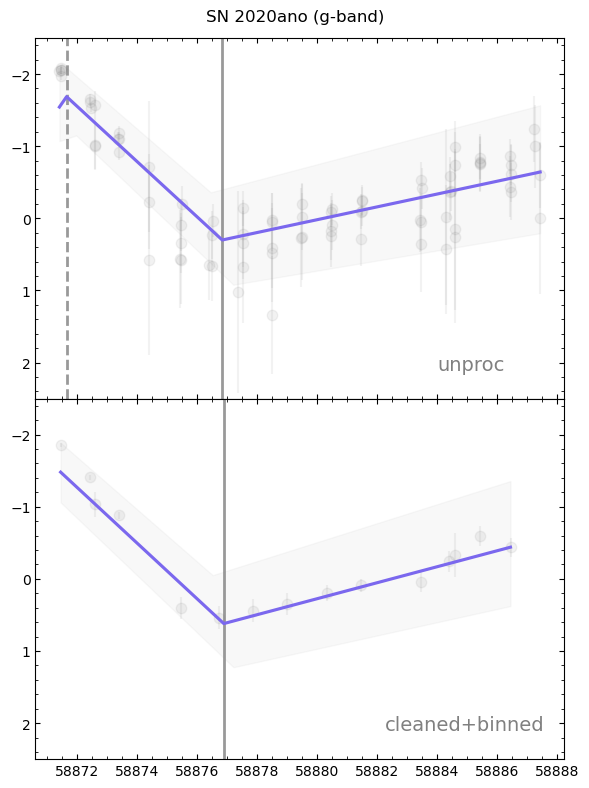

In [51]:
#bestfit_df_old, bestfit_df_new

# old MJD @ a2 = 58877.46900459984
# new: MJD @ a2 = 58900.27552596666
gridspec = dict(hspace=0.0)
fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)

#########plotting OLD
g_df = sn20ano[(sn20ano['filter']=='ZTF_g') | (sn20ano['filter']=='c')]
t_mjd = np.array(g_df['norm_t'])-15+old_a2_mjd
x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

best = np.array(sn20ano_old_fit_g).T[0] #bestfit values
lower_bound = np.array(sn20ano_old_fit_g).T[0] - np.array(sn20ano_old_fit_g).T[1] #50th ptile - diff_16ptile
upper_bound = np.array(sn20ano_old_fit_g).T[0] + np.array(sn20ano_old_fit_g).T[2] #50th ptile + diff_84ptile

#plotting mcmc results
ax[0].plot(x_plt-15+old_a2_mjd, np.array([model(best, v, r1=True) for v in x_plt]), c='mediumslateblue', label='20ano_old', linewidth=2.25)# linestyle=ls[i])
lower_curve = np.array([model(lower_bound, v, r1=True) for v in x_plt])
upper_curve = np.array([model(upper_bound, v, r1=True) for v in x_plt])
ax[0].fill_between(x_plt-15+old_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a1_g'].iloc[0]-15+old_a2_mjd,
              color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a2_g'].iloc[0]-15+old_a2_mjd,
              color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#plotting ztf data
x,y,yerr = t_mjd,np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
ax[0].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

ax[0].set_ylim(2.5,-2.5)
# ax[0].set_title('Old MCMC Fits')

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

plt.annotate('unproc',xy=(0.76,1.08),xycoords='axes fraction',color='gray',fontsize=14)



# #######plotting NEW
g_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_g') | (sn20ano_cl['filter']=='c')]
t_mjd = np.array(g_df['norm_t'])-15+new_a2_mjd
x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

best = np.array(sn20ano_new_fit_g).T[0] #bestfit values
lower_bound = np.array(sn20ano_new_fit_g).T[0] - np.array(sn20ano_new_fit_g).T[1] #50th ptile - diff_16ptile
upper_bound = np.array(sn20ano_new_fit_g).T[0] + np.array(sn20ano_new_fit_g).T[2] #50th ptile + diff_84ptile

#plotting mcmc results
ax[1].plot(x_plt-15+new_a2_mjd, np.array([model(best, v, r1=False) for v in x_plt]), c='mediumslateblue', label='20ano_new', linewidth=2.25)# linestyle=ls[i])
lower_curve = np.array([model(lower_bound, v, r1=False) for v in x_plt])
upper_curve = np.array([model(upper_bound, v, r1=False) for v in x_plt])
ax[1].fill_between(x_plt-15+new_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a1_g'].iloc[0]-15+new_a2_mjd,
                    color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a2_g'].iloc[0]-15+new_a2_mjd,
              color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#plotting ztf data
x,y,yerr = t_mjd,np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
ax[1].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

ax[1].set_ylim(2.5,-2.5)
# ax[1].set_title('Cleaned+Averaged MCMC Fits')

ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in",zorder=0)

plt.annotate('cleaned+binned',xy=(0.66,0.08),xycoords='axes fraction',color='gray',fontsize=14)

plt.suptitle('SN 2020ano (g-band)')
plt.tight_layout()

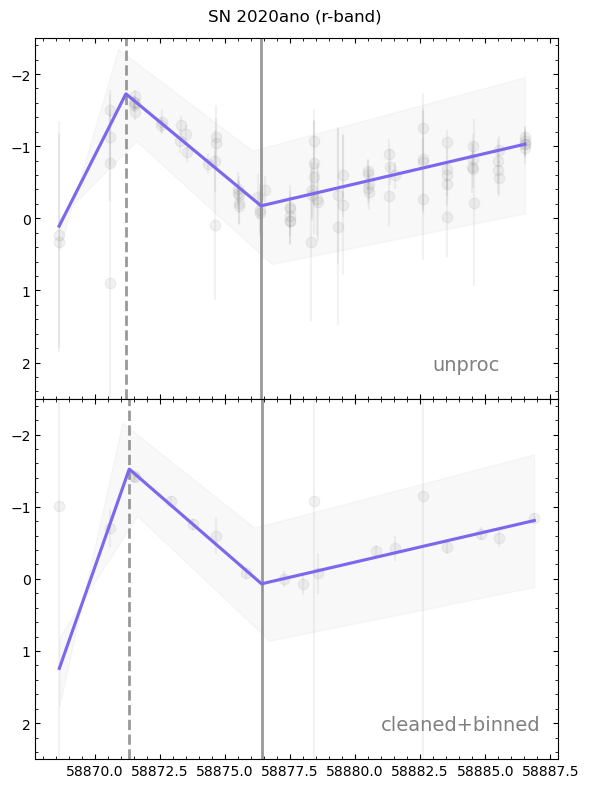

In [52]:
#bestfit_df_old, bestfit_df_new

gridspec = dict(hspace=0.0)
fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)

#########plotting OLD
r_df = sn20ano[(sn20ano['filter']=='ZTF_r') | (sn20ano['filter']=='o')]
t_mjd = np.array(r_df['norm_t'])-15+old_a2_mjd
x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

best = np.array(sn20ano_old_fit_r).T[0] #bestfit values
lower_bound = np.array(sn20ano_old_fit_r).T[0] - np.array(sn20ano_old_fit_r).T[1] #50th ptile - diff_16ptile
upper_bound = np.array(sn20ano_old_fit_r).T[0] + np.array(sn20ano_old_fit_r).T[2] #50th ptile + diff_84ptile

#plotting mcmc results
ax[0].plot(x_plt-15+old_a2_mjd, np.array([model(best, v, r1=True) for v in x_plt]), c='mediumslateblue', label='20ano_old', linewidth=2.25)# linestyle=ls[i])
lower_curve = np.array([model(lower_bound, v, r1=True) for v in x_plt])
upper_curve = np.array([model(upper_bound, v, r1=True) for v in x_plt])
ax[0].fill_between(x_plt-15+old_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a1_r'].iloc[0]-15+old_a2_mjd,
              color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a2_r'].iloc[0]-15+old_a2_mjd,
              color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#plotting ztf data
x,y,yerr = t_mjd,np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
ax[0].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

ax[0].set_ylim(2.5,-2.5)
# ax[0].set_title('Old MCMC Fits')

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

plt.annotate('unproc',xy=(0.76,1.08),xycoords='axes fraction',color='gray',fontsize=14)



# #######plotting NEW
r_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_r') | (sn20ano_cl['filter']=='o')]
t_mjd = np.array(r_df['norm_t'])-15+new_a2_mjd
x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

best = np.array(sn20ano_new_fit_r).T[0] #bestfit values
lower_bound = np.array(sn20ano_new_fit_r).T[0] - np.array(sn20ano_new_fit_r).T[1] #50th ptile - diff_16ptile
upper_bound = np.array(sn20ano_new_fit_r).T[0] + np.array(sn20ano_new_fit_r).T[2] #50th ptile + diff_84ptile

#plotting mcmc results
ax[1].plot(x_plt-15+new_a2_mjd, np.array([model(best, v, r1=True) for v in x_plt]), c='mediumslateblue', label='20ano_new', linewidth=2.25)# linestyle=ls[i])
lower_curve = np.array([model(lower_bound, v, r1=True) for v in x_plt])
upper_curve = np.array([model(upper_bound, v, r1=True) for v in x_plt])
ax[1].fill_between(x_plt-15+new_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a1_r'].iloc[0]-15+new_a2_mjd,
                    color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a2_r'].iloc[0]-15+new_a2_mjd,
              color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#plotting ztf data
x,y,yerr = t_mjd,np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
ax[1].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

ax[1].set_ylim(2.5,-2.5)
# ax[1].set_title('Cleaned+Averaged MCMC Fits')

ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in",zorder=0)

plt.annotate('cleaned+binned',xy=(0.66,0.08),xycoords='axes fraction',color='gray',fontsize=14)

plt.suptitle('SN 2020ano (r-band)')
plt.tight_layout()

In [53]:
def print_fit_comps(val):
    print('old fits:\n16th, 50th, 84th')
    print(round(bestfit_df_old[val].iloc[0]-low_err_df_old[val].iloc[0],3),
          round(bestfit_df_old[val].iloc[0],3),
          round(bestfit_df_old[val].iloc[0]+upp_err_df_old[val].iloc[0],3),
          '\n')
    print('new fits:\n16th, 50th, 84th')
    print(round(bestfit_df_new[val].iloc[0]-low_err_df_new[val].iloc[0],3),
          round(bestfit_df_new[val].iloc[0],3),
          round(bestfit_df_new[val].iloc[0]+upp_err_df_new[val].iloc[0],3)
          )

In [57]:
print('PARAM: m1_r')
print_fit_comps('m1_r') 
print('\n')

print('PARAM: m2_g')
print_fit_comps('m2_g') 
print('\n')

print('PARAM: m2_r')
print_fit_comps('m2_r') 
print('\n')

print('PARAM: m3_g')
print_fit_comps('m3_g') 
print('\n')

print('PARAM: m3_r')
print_fit_comps('m3_r') 
print('\n')

print('PARAM: a1_g')
print_fit_comps('a1_g')
print('\n')

print('PARAM: a1_r')
print_fit_comps('a1_r')
print('\n')

print('PARAM: a2_g')
print_fit_comps('a2_g')
print('\n')

print('PARAM: a2_r')
print_fit_comps('a2_r') 
print('\n')

PARAM: m1_r
old fits:
16th, 50th, 84th
-1.225 -0.715 -0.363 

new fits:
16th, 50th, 84th
-1.623 -1.029 -0.563


PARAM: m2_g
old fits:
16th, 50th, 84th
0.359 0.383 0.395 

new fits:
16th, 50th, 84th
0.362 0.386 0.397


PARAM: m2_r
old fits:
16th, 50th, 84th
0.273 0.299 0.328 

new fits:
16th, 50th, 84th
0.287 0.313 0.341


PARAM: m3_g
old fits:
16th, 50th, 84th
-0.11 -0.089 -0.07 

new fits:
16th, 50th, 84th
-0.131 -0.111 -0.092


PARAM: m3_r
old fits:
16th, 50th, 84th
-0.097 -0.084 -0.072 

new fits:
16th, 50th, 84th
-0.095 -0.084 -0.073


PARAM: a1_g
old fits:
16th, 50th, 84th
9.018 9.181 9.501 

new fits:
16th, 50th, 84th
nan nan nan


PARAM: a1_r
old fits:
16th, 50th, 84th
8.428 8.723 9.122 

new fits:
16th, 50th, 84th
8.801 9.065 9.368


PARAM: a2_g
old fits:
16th, 50th, 84th
13.989 14.372 14.741 

new fits:
16th, 50th, 84th
14.268 14.638 14.96


PARAM: a2_r
old fits:
16th, 50th, 84th
13.585 13.917 14.32 

new fits:
16th, 50th, 84th
13.871 14.149 14.444


